# Proyecto Analisis de Datos: Defuncion debido a covid 

In [74]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [63]:
#Buscar dataset con los diferentes estados de mexico
#el dataset se encuentra en el link : https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico?classId=13200a7b-1271-4411-8ef1-5b3184fe71ef&assignmentId=75eb9c46-0dd9-48f6-9e33-1a3d289c6cd3&submissionId=808db918-bb85-7a68-e2d4-dc58a7ae82f9
#debe importarlo en el mismo directorio donde se encuentre este notebook
df = pd.read_csv('230411COVID19MEXICO.csv')
#print(df.info())

C:\Users\yael_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [75]:
#Tomaremos solo los datos de los casos que ya fallecieron 
#quitamos los datos que no tienen fecha de defuncion(es decir tienen 9999-99-99 ya que aun no fallecen)
df1 = df.drop(df[df["FECHA_DEF"] == '9999-99-99'].index)


In [76]:
#Corroboramos que tenemos los datos de 467132 personas
num_filas = df1.shape[0]
num_filas

7137029

In [77]:
#le damos estructura mas amigable al dataframe y quitamos datos innecesarios
#trataremos de analizar los datos con todas estas variables
df1 = df1.drop(['OBESIDAD','FECHA_DEF','MUNICIPIO_RES','TIPO_PACIENTE','TABAQUISMO','ENTIDAD_NAC','ENTIDAD_UM','INTUBADO','NEUMONIA','NACIONALIDAD','EMBARAZO','ASMA','CARDIOVASCULAR','INDIGENA','SECTOR','MIGRANTE','ORIGEN','ID_REGISTRO','FECHA_INGRESO','FECHA_SINTOMAS','EPOC','INMUSUPR','OTRA_COM','TOMA_MUESTRA_LAB','HABLA_LENGUA_INDIG','TOMA_MUESTRA_ANTIGENO','CLASIFICACION_FINAL','PAIS_NACIONALIDAD','PAIS_ORIGEN','FECHA_ACTUALIZACION','OTRO_CASO'], axis=1)
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7137029 entries, 0 to 7137028
Data columns (total 9 columns):
 #   Column              Dtype
---  ------              -----
 0   SEXO                int64
 1   ENTIDAD_RES         int64
 2   EDAD                int64
 3   DIABETES            int64
 4   HIPERTENSION        int64
 5   RENAL_CRONICA       int64
 6   RESULTADO_LAB       int64
 7   RESULTADO_ANTIGENO  int64
 8   UCI                 int64
dtypes: int64(9)
memory usage: 544.5 MB
None


In [78]:
#Eliminamos datos inutiles para nuestro analisis, en este caso en varias categorias cuando los resultados son inconclusos 
#usan el numero 97,98 o 99 como referencia, eliminaremos esas filas, seria lo equivalente a eliminar nans
mask = (df1 == 99).any(axis=1)
df1 = df1.drop(df1[mask].index, axis=0)
mask = (df1 == 97).any(axis=1)
df1 = df1.drop(df1[mask].index, axis=0)
mask = (df1 == 98).any(axis=1)
df1 = df1.drop(df1[mask].index, axis=0)



#Eliminamos todos los resultados inconclusos y negativos a covid quitando los 3,4 de la columna de resultado_lab
mask = df1['RESULTADO_LAB'] == 3 
df1 = df1.drop(df1[mask].index, axis=0)
mask = df1['RESULTADO_LAB'] == 4 
df1 = df1.drop(df1[mask].index, axis=0)
mask = df1['RESULTADO_LAB'] == 2 
df1 = df1.drop(df1[mask].index, axis=0)


In [79]:
#Corroboramos que tenemos los datos correctos
num_filas = df1.shape[0]
num_filas
#tenemos unicamente datos utiles de casos de covid

29849

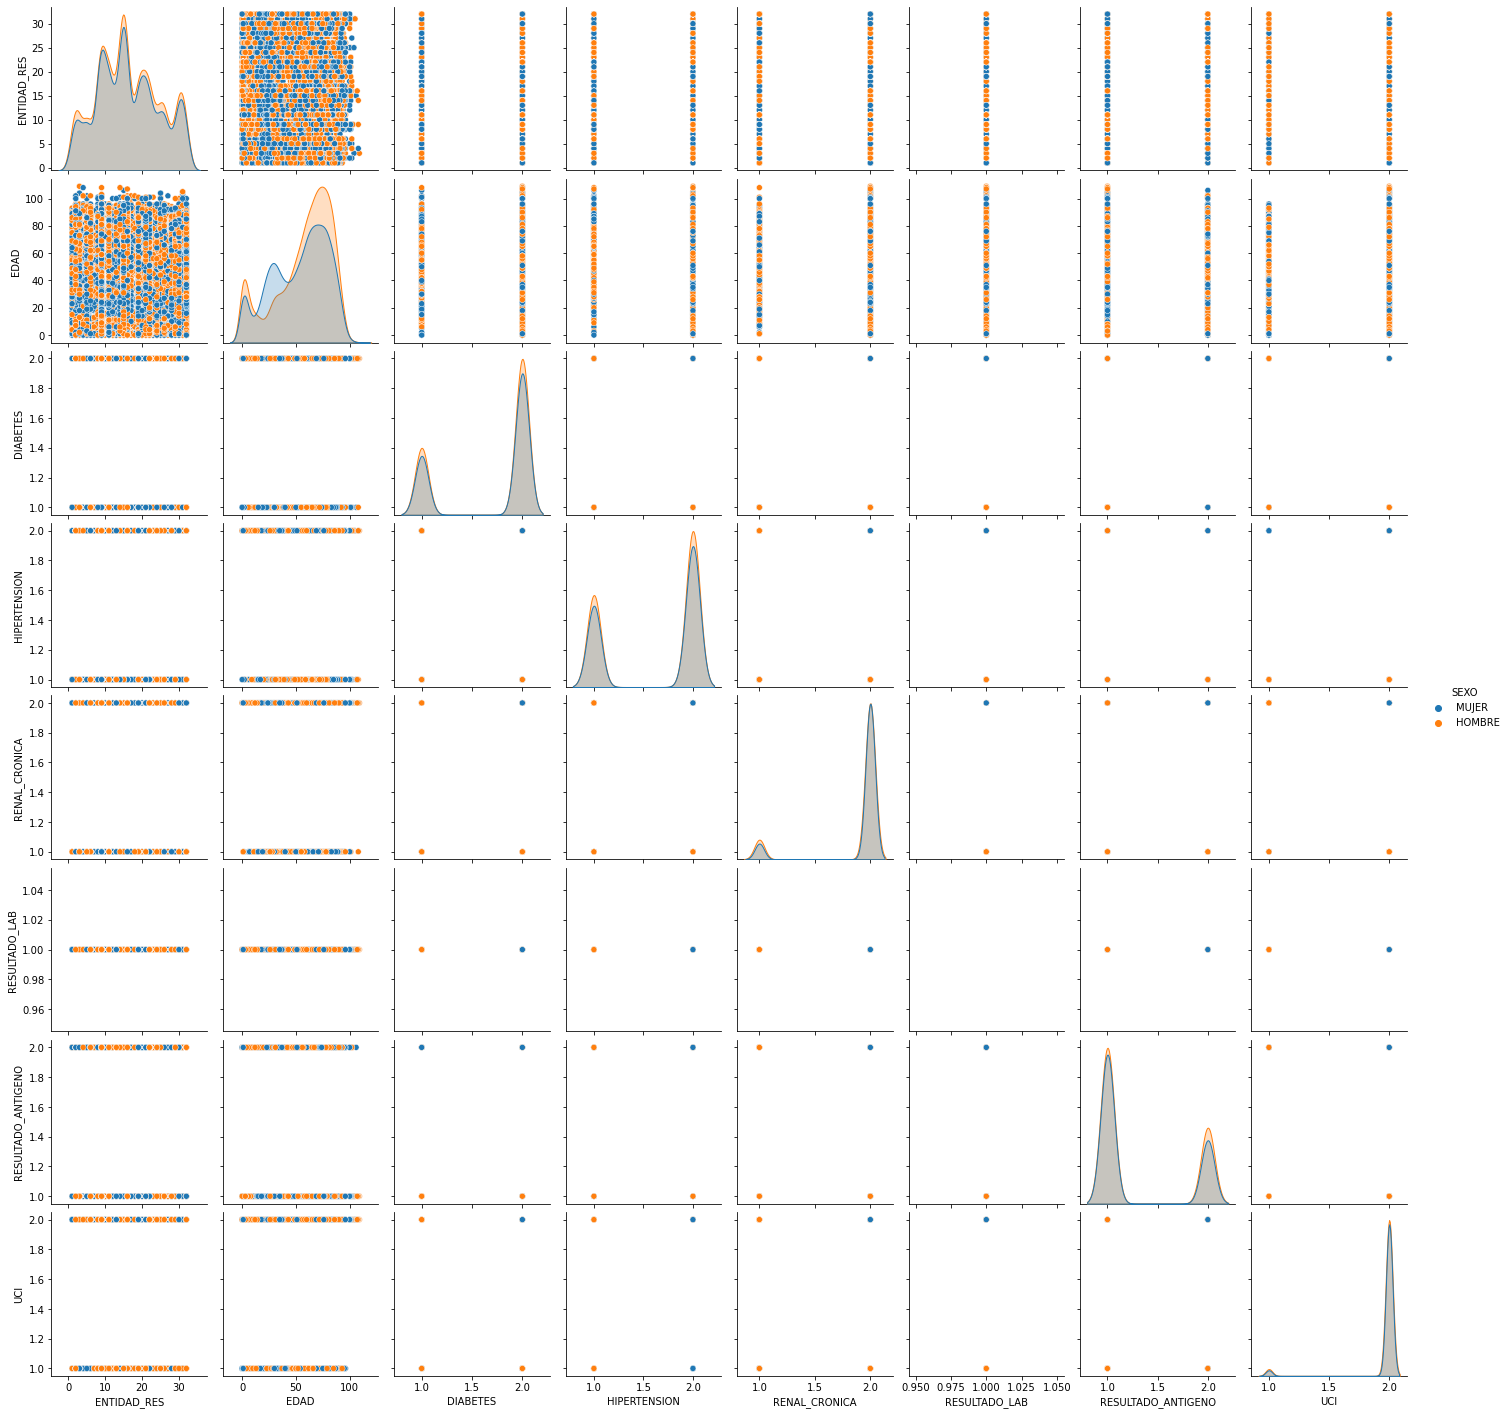

In [80]:
#Graficamos resultados por ejemplo probar pairplot
#Mapear los valores de la columna "covid" a "positivo" y "negativo"

#Mapeamos para sexo, masculino y femenino
df1["SEXO"] = df1["SEXO"].map({1: "MUJER", 2: "HOMBRE"})

#Graficar de manera categorica usando hue

sns.pairplot(df1,hue = 'SEXO')



In [71]:
#Volvemos a importar el archivo csv para evitar copias alteradas de los df
df = pd.read_csv('230411COVID19MEXICO.csv')
#Ahora buscamos correlacion y hacemos randomforest para 
#predecir dada persona en base a su sexo entidad de nacimiento y edad si morira si es positiva a covid o no
df2 = df
#Mapeamos de manera que si fallecio la columna cambiara por un 1, y si no ha fallecido por un 0
df2["FECHA_DEF"] = df2["FECHA_DEF"].map({'9999-99-99': 0}).fillna(1)

print(df2['FECHA_DEF'].value_counts())
#Nos quitamos las columnas innecesarias del dataframe
df2 = df2.drop(['OBESIDAD','RESULTADO_ANTIGENO','MUNICIPIO_RES','TIPO_PACIENTE','TABAQUISMO','ENTIDAD_NAC','ENTIDAD_UM','INTUBADO','NEUMONIA','NACIONALIDAD','EMBARAZO','ASMA','CARDIOVASCULAR','INDIGENA','SECTOR','MIGRANTE','ORIGEN','ID_REGISTRO','FECHA_INGRESO','FECHA_SINTOMAS','EPOC','INMUSUPR','OTRA_COM','TOMA_MUESTRA_LAB','HABLA_LENGUA_INDIG','TOMA_MUESTRA_ANTIGENO','CLASIFICACION_FINAL','PAIS_NACIONALIDAD','PAIS_ORIGEN','FECHA_ACTUALIZACION','OTRO_CASO'], axis=1)

print(df2['FECHA_DEF'].value_counts())
#Limipiamos los datos, ya que hay varias celdas con datos incompletos quitaremos las que tengan 97,98,99 en algun ya que de acuerdo al diccionaro del csv estos datos significan que no se tiene esta informacion
mask = (df2 == 99).any(axis=1)
df2 = df2.drop(df2[mask].index, axis=0)
mask = (df2 == 97).any(axis=1)
df2 = df2.drop(df2[mask].index, axis=0)
mask = (df2 == 98).any(axis=1)
df2 = df2.drop(df2[mask].index, axis=0)

print(df2['FECHA_DEF'].value_counts())

#Eliminamos todos los resultados inconclusos covid quitando los 3,4 de la columna de resultado_lab
mask = df2['RESULTADO_LAB'] == 3 
df2 = df2.drop(df2[mask].index, axis=0)
mask = df2['RESULTADO_LAB'] == 4 
df2 = df2.drop(df2[mask].index, axis=0)
mask = df2['RESULTADO_LAB'] == 2 
df2 = df2.drop(df2[mask].index, axis=0)

#Quitamos la columna de resultado de lab ya que todos los valores son positivos a covid
df2 = df2.drop("RESULTADO_LAB", axis=1)

df2['FECHA_DEF'].value_counts()

#Terminamos de limpiar los datos

0.0    7091472
1.0      45557
Name: FECHA_DEF, dtype: int64
0.0    7091472
1.0      45557
Name: FECHA_DEF, dtype: int64
0.0    161524
1.0     27521
Name: FECHA_DEF, dtype: int64


0.0    36268
1.0    13964
Name: FECHA_DEF, dtype: int64

In [72]:
df2.columns

Index(['SEXO', 'ENTIDAD_RES', 'FECHA_DEF', 'EDAD', 'DIABETES', 'HIPERTENSION',
       'RENAL_CRONICA', 'UCI'],
      dtype='object')

Score:  0.6987392169873922


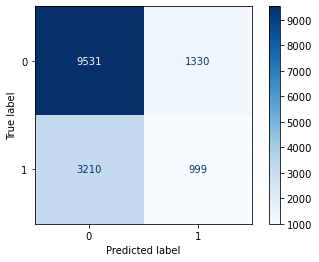

In [73]:
#Primero, en base a el estado de residencia,la edad,y el sexo
#es decir que prediga dados estos datos de una persona positiva a covid, si morira o no
#no hace falta transformar los datos ya que ya vienen numericamente
#Donde 1 significa que el paciente sigue vivo y 0 que fallecio
y = df2['FECHA_DEF']
X = df2.drop(["FECHA_DEF",'DIABETES','HIPERTENSION','RENAL_CRONICA','UCI'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0 )
forest = RandomForestClassifier(n_estimators = 5000)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print('Score: ', forest.score(X_test, y_test))

matriz_confusion = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(matriz_confusion).plot(cmap=plt.cm.Blues);



Score:  0.720836098208361


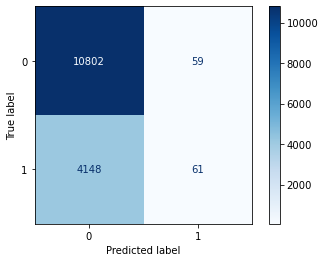

In [81]:
# Veremos como hace predicciones basandonos en si tienen diabetes, hipertension, alguna complicacion renal y si estuvieron en cuidados intensivos

y = df2['FECHA_DEF']
X = df2.drop(["FECHA_DEF",'EDAD','ENTIDAD_RES','SEXO'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0 )
forest = RandomForestClassifier(n_estimators = 1000)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print('Score: ', forest.score(X_test, y_test))

matriz_confusion = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(matriz_confusion).plot(cmap=plt.cm.Blues);

Score:  0.683344392833444


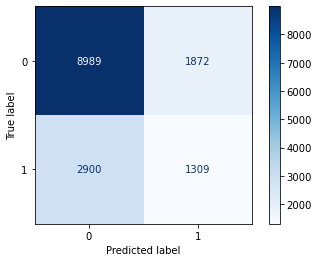

In [82]:
#y por ultimo basandonos en todos los factores edad,sexo, estado de residencia, diabetes, hipertension, problemas renales y cuidados intensivos
y = df2['FECHA_DEF']
X = df2.drop(["FECHA_DEF"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0 )
forest = RandomForestClassifier(n_estimators = 1000)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print('Score: ', forest.score(X_test, y_test))

matriz_confusion = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(matriz_confusion).plot(cmap=plt.cm.Blues);